In [2]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
import csv

Using TensorFlow backend.


In [2]:
total = []

data_files = ['augmented/subtask_B_train_and_dev_dataset.csv', 'augmented/subtask_B_train_and_dev_generated_dataset.csv']

for file in data_files: 

    with open(file, 'r') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        next(csvreader, None)

        for row in csvreader:
            total.append(row)


In [3]:
def return_without_idx(el):
    return el[1:]

updated_total = list(map(return_without_idx, total))

np.random.shuffle(updated_total)

In [4]:
def label_to_class(val):
    if val == "Irrelevant":
        return 0
    return 1

In [5]:
with open('augmented/final_train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['id', 'qid1', 'qid2', 'question1', 'question2', 'relevance'])
    
    for idx, elem in enumerate(updated_total[:9000]):
        writer.writerow([idx, idx*2+1, idx*2+2, elem[2], elem[3], label_to_class(elem[4])])
    
with open('augmented/final_test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['id', 'qid1', 'qid2', 'question1', 'question2', 'relevance'])
    
    for idx, elem in enumerate(updated_total[9000:]):
        writer.writerow([idx, idx*2+1, idx*2+2, elem[2], elem[3], label_to_class(elem[4])])


In [19]:
TRAIN_CSV = 'augmented/final_train.csv'
TEST_CSV = 'augmented/final_test.csv'
EMBEDDING_FILE = '../GoogleNews-vectors-negative300.bin.gz'
import pandas as pd
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

stops = set(stopwords.words('english'))

In [20]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

vocabulary = dict()
inverse_vocabulary = ['<unk>']

print("Started loading google vectors...")
# '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

print("Finished loading google vectors...")

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():
        


        # Iterate through the text of both questions of the row
        for question in questions_cols:
            
            print(index, question)
            
            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):
                
#                 print(word + "\n")

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

Started loading google vectors...
Finished loading google vectors...
0 question1
0 question2
1 question1
1 question2
2 question1
2 question2
3 question1
3 question2
4 question1
4 question2
5 question1
5 question2
6 question1
6 question2
7 question1
7 question2
8 question1
8 question2
9 question1
9 question2
10 question1
10 question2
11 question1
11 question2
12 question1
12 question2
13 question1
13 question2
14 question1
14 question2
15 question1
15 question2
16 question1
16 question2
17 question1
17 question2
18 question1
18 question2
19 question1
19 question2
20 question1
20 question2
21 question1
21 question2
22 question1
22 question2
23 question1
23 question2
24 question1
24 question2
25 question1
25 question2
26 question1
26 question2
27 question1
27 question2
28 question1
28 question2
29 question1
29 question2
30 question1
30 question2
31 question1
31 question2
32 question1
32 question2
33 question1
33 question2
34 question1
34 question2
35 question1
35 question2
36 question1
36

556 question2
557 question1
557 question2
558 question1
558 question2
559 question1
559 question2
560 question1
560 question2
561 question1
561 question2
562 question1
562 question2
563 question1
563 question2
564 question1
564 question2
565 question1
565 question2
566 question1
566 question2
567 question1
567 question2
568 question1
568 question2
569 question1
569 question2
570 question1
570 question2
571 question1
571 question2
572 question1
572 question2
573 question1
573 question2
574 question1
574 question2
575 question1
575 question2
576 question1
576 question2
577 question1
577 question2
578 question1
578 question2
579 question1
579 question2
580 question1
580 question2
581 question1
581 question2
582 question1
582 question2
583 question1
583 question2
584 question1
584 question2
585 question1
585 question2
586 question1
586 question2
587 question1
587 question2
588 question1
588 question2
589 question1
589 question2
590 question1
590 question2
591 question1
591 question2
592 qu

1182 question2
1183 question1
1183 question2
1184 question1
1184 question2
1185 question1
1185 question2
1186 question1
1186 question2
1187 question1
1187 question2
1188 question1
1188 question2
1189 question1
1189 question2
1190 question1
1190 question2
1191 question1
1191 question2
1192 question1
1192 question2
1193 question1
1193 question2
1194 question1
1194 question2
1195 question1
1195 question2
1196 question1
1196 question2
1197 question1
1197 question2
1198 question1
1198 question2
1199 question1
1199 question2
1200 question1
1200 question2
1201 question1
1201 question2
1202 question1
1202 question2
1203 question1
1203 question2
1204 question1
1204 question2
1205 question1
1205 question2
1206 question1
1206 question2
1207 question1
1207 question2
1208 question1
1208 question2
1209 question1
1209 question2
1210 question1
1210 question2
1211 question1
1211 question2
1212 question1
1212 question2
1213 question1
1213 question2
1214 question1
1214 question2
1215 question1
1215 quest

1474 question1
1474 question2
1475 question1
1475 question2
1476 question1
1476 question2
1477 question1
1477 question2
1478 question1
1478 question2
1479 question1
1479 question2
1480 question1
1480 question2
1481 question1
1481 question2
1482 question1
1482 question2
1483 question1
1483 question2
1484 question1
1484 question2
1485 question1
1485 question2
1486 question1
1486 question2
1487 question1
1487 question2
1488 question1
1488 question2
1489 question1
1489 question2
1490 question1
1490 question2
1491 question1
1491 question2
1492 question1
1492 question2
1493 question1
1493 question2
1494 question1
1494 question2
1495 question1
1495 question2
1496 question1
1496 question2
1497 question1
1497 question2
1498 question1
1498 question2
1499 question1
1499 question2
1500 question1
1500 question2
1501 question1
1501 question2
1502 question1
1502 question2
1503 question1
1503 question2
1504 question1
1504 question2
1505 question1
1505 question2
1506 question1
1506 question2
1507 quest

1806 question1
1806 question2
1807 question1
1807 question2
1808 question1
1808 question2
1809 question1
1809 question2
1810 question1
1810 question2
1811 question1
1811 question2
1812 question1
1812 question2
1813 question1
1813 question2
1814 question1
1814 question2
1815 question1
1815 question2
1816 question1
1816 question2
1817 question1
1817 question2
1818 question1
1818 question2
1819 question1
1819 question2
1820 question1
1820 question2
1821 question1
1821 question2
1822 question1
1822 question2
1823 question1
1823 question2
1824 question1
1824 question2
1825 question1
1825 question2
1826 question1
1826 question2
1827 question1
1827 question2
1828 question1
1828 question2
1829 question1
1829 question2
1830 question1
1830 question2
1831 question1
1831 question2
1832 question1
1832 question2
1833 question1
1833 question2
1834 question1
1834 question2
1835 question1
1835 question2
1836 question1
1836 question2
1837 question1
1837 question2
1838 question1
1838 question2
1839 quest

2407 question2
2408 question1
2408 question2
2409 question1
2409 question2
2410 question1
2410 question2
2411 question1
2411 question2
2412 question1
2412 question2
2413 question1
2413 question2
2414 question1
2414 question2
2415 question1
2415 question2
2416 question1
2416 question2
2417 question1
2417 question2
2418 question1
2418 question2
2419 question1
2419 question2
2420 question1
2420 question2
2421 question1
2421 question2
2422 question1
2422 question2
2423 question1
2423 question2
2424 question1
2424 question2
2425 question1
2425 question2
2426 question1
2426 question2
2427 question1
2427 question2
2428 question1
2428 question2
2429 question1
2429 question2
2430 question1
2430 question2
2431 question1
2431 question2
2432 question1
2432 question2
2433 question1
2433 question2
2434 question1
2434 question2
2435 question1
2435 question2
2436 question1
2436 question2
2437 question1
2437 question2
2438 question1
2438 question2
2439 question1
2439 question2
2440 question1
2440 quest

2688 question1
2688 question2
2689 question1
2689 question2
2690 question1
2690 question2
2691 question1
2691 question2
2692 question1
2692 question2
2693 question1
2693 question2
2694 question1
2694 question2
2695 question1
2695 question2
2696 question1
2696 question2
2697 question1
2697 question2
2698 question1
2698 question2
2699 question1
2699 question2
2700 question1
2700 question2
2701 question1
2701 question2
2702 question1
2702 question2
2703 question1
2703 question2
2704 question1
2704 question2
2705 question1
2705 question2
2706 question1
2706 question2
2707 question1
2707 question2
2708 question1
2708 question2
2709 question1
2709 question2
2710 question1
2710 question2
2711 question1
2711 question2
2712 question1
2712 question2
2713 question1
2713 question2
2714 question1
2714 question2
2715 question1
2715 question2
2716 question1
2716 question2
2717 question1
2717 question2
2718 question1
2718 question2
2719 question1
2719 question2
2720 question1
2720 question2
2721 quest

2997 question2
2998 question1
2998 question2
2999 question1
2999 question2
3000 question1
3000 question2
3001 question1
3001 question2
3002 question1
3002 question2
3003 question1
3003 question2
3004 question1
3004 question2
3005 question1
3005 question2
3006 question1
3006 question2
3007 question1
3007 question2
3008 question1
3008 question2
3009 question1
3009 question2
3010 question1
3010 question2
3011 question1
3011 question2
3012 question1
3012 question2
3013 question1
3013 question2
3014 question1
3014 question2
3015 question1
3015 question2
3016 question1
3016 question2
3017 question1
3017 question2
3018 question1
3018 question2
3019 question1
3019 question2
3020 question1
3020 question2
3021 question1
3021 question2
3022 question1
3022 question2
3023 question1
3023 question2
3024 question1
3024 question2
3025 question1
3025 question2
3026 question1
3026 question2
3027 question1
3027 question2
3028 question1
3028 question2
3029 question1
3029 question2
3030 question1
3030 quest

3310 question2
3311 question1
3311 question2
3312 question1
3312 question2
3313 question1
3313 question2
3314 question1
3314 question2
3315 question1
3315 question2
3316 question1
3316 question2
3317 question1
3317 question2
3318 question1
3318 question2
3319 question1
3319 question2
3320 question1
3320 question2
3321 question1
3321 question2
3322 question1
3322 question2
3323 question1
3323 question2
3324 question1
3324 question2
3325 question1
3325 question2
3326 question1
3326 question2
3327 question1
3327 question2
3328 question1
3328 question2
3329 question1
3329 question2
3330 question1
3330 question2
3331 question1
3331 question2
3332 question1
3332 question2
3333 question1
3333 question2
3334 question1
3334 question2
3335 question1
3335 question2
3336 question1
3336 question2
3337 question1
3337 question2
3338 question1
3338 question2
3339 question1
3339 question2
3340 question1
3340 question2
3341 question1
3341 question2
3342 question1
3342 question2
3343 question1
3343 quest

3584 question1
3584 question2
3585 question1
3585 question2
3586 question1
3586 question2
3587 question1
3587 question2
3588 question1
3588 question2
3589 question1
3589 question2
3590 question1
3590 question2
3591 question1
3591 question2
3592 question1
3592 question2
3593 question1
3593 question2
3594 question1
3594 question2
3595 question1
3595 question2
3596 question1
3596 question2
3597 question1
3597 question2
3598 question1
3598 question2
3599 question1
3599 question2
3600 question1
3600 question2
3601 question1
3601 question2
3602 question1
3602 question2
3603 question1
3603 question2
3604 question1
3604 question2
3605 question1
3605 question2
3606 question1
3606 question2
3607 question1
3607 question2
3608 question1
3608 question2
3609 question1
3609 question2
3610 question1
3610 question2
3611 question1
3611 question2
3612 question1
3612 question2
3613 question1
3613 question2
3614 question1
3614 question2
3615 question1
3615 question2
3616 question1
3616 question2
3617 quest

3930 question2
3931 question1
3931 question2
3932 question1
3932 question2
3933 question1
3933 question2
3934 question1
3934 question2
3935 question1
3935 question2
3936 question1
3936 question2
3937 question1
3937 question2
3938 question1
3938 question2
3939 question1
3939 question2
3940 question1
3940 question2
3941 question1
3941 question2
3942 question1
3942 question2
3943 question1
3943 question2
3944 question1
3944 question2
3945 question1
3945 question2
3946 question1
3946 question2
3947 question1
3947 question2
3948 question1
3948 question2
3949 question1
3949 question2
3950 question1
3950 question2
3951 question1
3951 question2
3952 question1
3952 question2
3953 question1
3953 question2
3954 question1
3954 question2
3955 question1
3955 question2
3956 question1
3956 question2
3957 question1
3957 question2
3958 question1
3958 question2
3959 question1
3959 question2
3960 question1
3960 question2
3961 question1
3961 question2
3962 question1
3962 question2
3963 question1
3963 quest

4537 question1
4537 question2
4538 question1
4538 question2
4539 question1
4539 question2
4540 question1
4540 question2
4541 question1
4541 question2
4542 question1
4542 question2
4543 question1
4543 question2
4544 question1
4544 question2
4545 question1
4545 question2
4546 question1
4546 question2
4547 question1
4547 question2
4548 question1
4548 question2
4549 question1
4549 question2
4550 question1
4550 question2
4551 question1
4551 question2
4552 question1
4552 question2
4553 question1
4553 question2
4554 question1
4554 question2
4555 question1
4555 question2
4556 question1
4556 question2
4557 question1
4557 question2
4558 question1
4558 question2
4559 question1
4559 question2
4560 question1
4560 question2
4561 question1
4561 question2
4562 question1
4562 question2
4563 question1
4563 question2
4564 question1
4564 question2
4565 question1
4565 question2
4566 question1
4566 question2
4567 question1
4567 question2
4568 question1
4568 question2
4569 question1
4569 question2
4570 quest

5108 question2
5109 question1
5109 question2
5110 question1
5110 question2
5111 question1
5111 question2
5112 question1
5112 question2
5113 question1
5113 question2
5114 question1
5114 question2
5115 question1
5115 question2
5116 question1
5116 question2
5117 question1
5117 question2
5118 question1
5118 question2
5119 question1
5119 question2
5120 question1
5120 question2
5121 question1
5121 question2
5122 question1
5122 question2
5123 question1
5123 question2
5124 question1
5124 question2
5125 question1
5125 question2
5126 question1
5126 question2
5127 question1
5127 question2
5128 question1
5128 question2
5129 question1
5129 question2
5130 question1
5130 question2
5131 question1
5131 question2
5132 question1
5132 question2
5133 question1
5133 question2
5134 question1
5134 question2
5135 question1
5135 question2
5136 question1
5136 question2
5137 question1
5137 question2
5138 question1
5138 question2
5139 question1
5139 question2
5140 question1
5140 question2
5141 question1
5141 quest

5438 question1
5438 question2
5439 question1
5439 question2
5440 question1
5440 question2
5441 question1
5441 question2
5442 question1
5442 question2
5443 question1
5443 question2
5444 question1
5444 question2
5445 question1
5445 question2
5446 question1
5446 question2
5447 question1
5447 question2
5448 question1
5448 question2
5449 question1
5449 question2
5450 question1
5450 question2
5451 question1
5451 question2
5452 question1
5452 question2
5453 question1
5453 question2
5454 question1
5454 question2
5455 question1
5455 question2
5456 question1
5456 question2
5457 question1
5457 question2
5458 question1
5458 question2
5459 question1
5459 question2
5460 question1
5460 question2
5461 question1
5461 question2
5462 question1
5462 question2
5463 question1
5463 question2
5464 question1
5464 question2
5465 question1
5465 question2
5466 question1
5466 question2
5467 question1
5467 question2
5468 question1
5468 question2
5469 question1
5469 question2
5470 question1
5470 question2
5471 quest

6036 question2
6037 question1
6037 question2
6038 question1
6038 question2
6039 question1
6039 question2
6040 question1
6040 question2
6041 question1
6041 question2
6042 question1
6042 question2
6043 question1
6043 question2
6044 question1
6044 question2
6045 question1
6045 question2
6046 question1
6046 question2
6047 question1
6047 question2
6048 question1
6048 question2
6049 question1
6049 question2
6050 question1
6050 question2
6051 question1
6051 question2
6052 question1
6052 question2
6053 question1
6053 question2
6054 question1
6054 question2
6055 question1
6055 question2
6056 question1
6056 question2
6057 question1
6057 question2
6058 question1
6058 question2
6059 question1
6059 question2
6060 question1
6060 question2
6061 question1
6061 question2
6062 question1
6062 question2
6063 question1
6063 question2
6064 question1
6064 question2
6065 question1
6065 question2
6066 question1
6066 question2
6067 question1
6067 question2
6068 question1
6068 question2
6069 question1
6069 quest

6531 question1
6531 question2
6532 question1
6532 question2
6533 question1
6533 question2
6534 question1
6534 question2
6535 question1
6535 question2
6536 question1
6536 question2
6537 question1
6537 question2
6538 question1
6538 question2
6539 question1
6539 question2
6540 question1
6540 question2
6541 question1
6541 question2
6542 question1
6542 question2
6543 question1
6543 question2
6544 question1
6544 question2
6545 question1
6545 question2
6546 question1
6546 question2
6547 question1
6547 question2
6548 question1
6548 question2
6549 question1
6549 question2
6550 question1
6550 question2
6551 question1
6551 question2
6552 question1
6552 question2
6553 question1
6553 question2
6554 question1
6554 question2
6555 question1
6555 question2
6556 question1
6556 question2
6557 question1
6557 question2
6558 question1
6558 question2
6559 question1
6559 question2
6560 question1
6560 question2
6561 question1
6561 question2
6562 question1
6562 question2
6563 question1
6563 question2
6564 quest

7055 question2
7056 question1
7056 question2
7057 question1
7057 question2
7058 question1
7058 question2
7059 question1
7059 question2
7060 question1
7060 question2
7061 question1
7061 question2
7062 question1
7062 question2
7063 question1
7063 question2
7064 question1
7064 question2
7065 question1
7065 question2
7066 question1
7066 question2
7067 question1
7067 question2
7068 question1
7068 question2
7069 question1
7069 question2
7070 question1
7070 question2
7071 question1
7071 question2
7072 question1
7072 question2
7073 question1
7073 question2
7074 question1
7074 question2
7075 question1
7075 question2
7076 question1
7076 question2
7077 question1
7077 question2
7078 question1
7078 question2
7079 question1
7079 question2
7080 question1
7080 question2
7081 question1
7081 question2
7082 question1
7082 question2
7083 question1
7083 question2
7084 question1
7084 question2
7085 question1
7085 question2
7086 question1
7086 question2
7087 question1
7087 question2
7088 question1
7088 quest

7348 question1
7348 question2
7349 question1
7349 question2
7350 question1
7350 question2
7351 question1
7351 question2
7352 question1
7352 question2
7353 question1
7353 question2
7354 question1
7354 question2
7355 question1
7355 question2
7356 question1
7356 question2
7357 question1
7357 question2
7358 question1
7358 question2
7359 question1
7359 question2
7360 question1
7360 question2
7361 question1
7361 question2
7362 question1
7362 question2
7363 question1
7363 question2
7364 question1
7364 question2
7365 question1
7365 question2
7366 question1
7366 question2
7367 question1
7367 question2
7368 question1
7368 question2
7369 question1
7369 question2
7370 question1
7370 question2
7371 question1
7371 question2
7372 question1
7372 question2
7373 question1
7373 question2
7374 question1
7374 question2
7375 question1
7375 question2
7376 question1
7376 question2
7377 question1
7377 question2
7378 question1
7378 question2
7379 question1
7379 question2
7380 question1
7380 question2
7381 quest

7683 question2
7684 question1
7684 question2
7685 question1
7685 question2
7686 question1
7686 question2
7687 question1
7687 question2
7688 question1
7688 question2
7689 question1
7689 question2
7690 question1
7690 question2
7691 question1
7691 question2
7692 question1
7692 question2
7693 question1
7693 question2
7694 question1
7694 question2
7695 question1
7695 question2
7696 question1
7696 question2
7697 question1
7697 question2
7698 question1
7698 question2
7699 question1
7699 question2
7700 question1
7700 question2
7701 question1
7701 question2
7702 question1
7702 question2
7703 question1
7703 question2
7704 question1
7704 question2
7705 question1
7705 question2
7706 question1
7706 question2
7707 question1
7707 question2
7708 question1
7708 question2
7709 question1
7709 question2
7710 question1
7710 question2
7711 question1
7711 question2
7712 question1
7712 question2
7713 question1
7713 question2
7714 question1
7714 question2
7715 question1
7715 question2
7716 question1
7716 quest

7980 question1
7980 question2
7981 question1
7981 question2
7982 question1
7982 question2
7983 question1
7983 question2
7984 question1
7984 question2
7985 question1
7985 question2
7986 question1
7986 question2
7987 question1
7987 question2
7988 question1
7988 question2
7989 question1
7989 question2
7990 question1
7990 question2
7991 question1
7991 question2
7992 question1
7992 question2
7993 question1
7993 question2
7994 question1
7994 question2
7995 question1
7995 question2
7996 question1
7996 question2
7997 question1
7997 question2
7998 question1
7998 question2
7999 question1
7999 question2
8000 question1
8000 question2
8001 question1
8001 question2
8002 question1
8002 question2
8003 question1
8003 question2
8004 question1
8004 question2
8005 question1
8005 question2
8006 question1
8006 question2
8007 question1
8007 question2
8008 question1
8008 question2
8009 question1
8009 question2
8010 question1
8010 question2
8011 question1
8011 question2
8012 question1
8012 question2
8013 quest

8313 question1
8313 question2
8314 question1
8314 question2
8315 question1
8315 question2
8316 question1
8316 question2
8317 question1
8317 question2
8318 question1
8318 question2
8319 question1
8319 question2
8320 question1
8320 question2
8321 question1
8321 question2
8322 question1
8322 question2
8323 question1
8323 question2
8324 question1
8324 question2
8325 question1
8325 question2
8326 question1
8326 question2
8327 question1
8327 question2
8328 question1
8328 question2
8329 question1
8329 question2
8330 question1
8330 question2
8331 question1
8331 question2
8332 question1
8332 question2
8333 question1
8333 question2
8334 question1
8334 question2
8335 question1
8335 question2
8336 question1
8336 question2
8337 question1
8337 question2
8338 question1
8338 question2
8339 question1
8339 question2
8340 question1
8340 question2
8341 question1
8341 question2
8342 question1
8342 question2
8343 question1
8343 question2
8344 question1
8344 question2
8345 question1
8345 question2
8346 quest

8616 question2
8617 question1
8617 question2
8618 question1
8618 question2
8619 question1
8619 question2
8620 question1
8620 question2
8621 question1
8621 question2
8622 question1
8622 question2
8623 question1
8623 question2
8624 question1
8624 question2
8625 question1
8625 question2
8626 question1
8626 question2
8627 question1
8627 question2
8628 question1
8628 question2
8629 question1
8629 question2
8630 question1
8630 question2
8631 question1
8631 question2
8632 question1
8632 question2
8633 question1
8633 question2
8634 question1
8634 question2
8635 question1
8635 question2
8636 question1
8636 question2
8637 question1
8637 question2
8638 question1
8638 question2
8639 question1
8639 question2
8640 question1
8640 question2
8641 question1
8641 question2
8642 question1
8642 question2
8643 question1
8643 question2
8644 question1
8644 question2
8645 question1
8645 question2
8646 question1
8646 question2
8647 question1
8647 question2
8648 question1
8648 question2
8649 question1
8649 quest

8926 question1
8926 question2
8927 question1
8927 question2
8928 question1
8928 question2
8929 question1
8929 question2
8930 question1
8930 question2
8931 question1
8931 question2
8932 question1
8932 question2
8933 question1
8933 question2
8934 question1
8934 question2
8935 question1
8935 question2
8936 question1
8936 question2
8937 question1
8937 question2
8938 question1
8938 question2
8939 question1
8939 question2
8940 question1
8940 question2
8941 question1
8941 question2
8942 question1
8942 question2
8943 question1
8943 question2
8944 question1
8944 question2
8945 question1
8945 question2
8946 question1
8946 question2
8947 question1
8947 question2
8948 question1
8948 question2
8949 question1
8949 question2
8950 question1
8950 question2
8951 question1
8951 question2
8952 question1
8952 question2
8953 question1
8953 question2
8954 question1
8954 question2
8955 question1
8955 question2
8956 question1
8956 question2
8957 question1
8957 question2
8958 question1
8958 question2
8959 quest

472 question1
472 question2
473 question1
473 question2
474 question1
474 question2
475 question1
475 question2
476 question1
476 question2
477 question1
477 question2
478 question1
478 question2
479 question1
479 question2
480 question1
480 question2
481 question1
481 question2
482 question1
482 question2
483 question1
483 question2
484 question1
484 question2
485 question1
485 question2
486 question1
486 question2
487 question1
487 question2
488 question1
488 question2
489 question1
489 question2
490 question1
490 question2
491 question1
491 question2
492 question1
492 question2
493 question1
493 question2
494 question1
494 question2
495 question1
495 question2
496 question1
496 question2
497 question1
497 question2
498 question1
498 question2
499 question1
499 question2
500 question1
500 question2
501 question1
501 question2
502 question1
502 question2
503 question1
503 question2
504 question1
504 question2
505 question1
505 question2
506 question1
506 question2
507 question1
507 qu

810 question1
810 question2
811 question1
811 question2
812 question1
812 question2
813 question1
813 question2
814 question1
814 question2
815 question1
815 question2
816 question1
816 question2
817 question1
817 question2
818 question1
818 question2
819 question1
819 question2
820 question1
820 question2
821 question1
821 question2
822 question1
822 question2
823 question1
823 question2
824 question1
824 question2
825 question1
825 question2
826 question1
826 question2
827 question1
827 question2
828 question1
828 question2
829 question1
829 question2
830 question1
830 question2
831 question1
831 question2
832 question1
832 question2
833 question1
833 question2
834 question1
834 question2
835 question1
835 question2
836 question1
836 question2
837 question1
837 question2
838 question1
838 question2
839 question1
839 question2
840 question1
840 question2
841 question1
841 question2
842 question1
842 question2
843 question1
843 question2
844 question1
844 question2
845 question1
845 qu

1101 question2
1102 question1
1102 question2
1103 question1
1103 question2
1104 question1
1104 question2
1105 question1
1105 question2
1106 question1
1106 question2
1107 question1
1107 question2
1108 question1
1108 question2
1109 question1
1109 question2
1110 question1
1110 question2
1111 question1
1111 question2
1112 question1
1112 question2
1113 question1
1113 question2
1114 question1
1114 question2
1115 question1
1115 question2
1116 question1
1116 question2
1117 question1
1117 question2
1118 question1
1118 question2
1119 question1
1119 question2
1120 question1
1120 question2
1121 question1
1121 question2
1122 question1
1122 question2
1123 question1
1123 question2
1124 question1
1124 question2
1125 question1
1125 question2
1126 question1
1126 question2
1127 question1
1127 question2
1128 question1
1128 question2
1129 question1
1129 question2
1130 question1
1130 question2
1131 question1
1131 question2
1132 question1
1132 question2
1133 question1
1133 question2
1134 question1
1134 quest

1428 question1
1428 question2
1429 question1
1429 question2
1430 question1
1430 question2
1431 question1
1431 question2
1432 question1
1432 question2
1433 question1
1433 question2
1434 question1
1434 question2
1435 question1
1435 question2
1436 question1
1436 question2
1437 question1
1437 question2
1438 question1
1438 question2
1439 question1
1439 question2
1440 question1
1440 question2
1441 question1
1441 question2
1442 question1
1442 question2
1443 question1
1443 question2
1444 question1
1444 question2
1445 question1
1445 question2
1446 question1
1446 question2
1447 question1
1447 question2
1448 question1
1448 question2
1449 question1
1449 question2
1450 question1
1450 question2
1451 question1
1451 question2
1452 question1
1452 question2
1453 question1
1453 question2
1454 question1
1454 question2
1455 question1
1455 question2
1456 question1
1456 question2
1457 question1
1457 question2
1458 question1
1458 question2
1459 question1
1459 question2
1460 question1
1460 question2
1461 quest

2027 question2
2028 question1
2028 question2
2029 question1
2029 question2
2030 question1
2030 question2
2031 question1
2031 question2
2032 question1
2032 question2
2033 question1
2033 question2
2034 question1
2034 question2
2035 question1
2035 question2
2036 question1
2036 question2
2037 question1
2037 question2
2038 question1
2038 question2
2039 question1
2039 question2
2040 question1
2040 question2
2041 question1
2041 question2
2042 question1
2042 question2
2043 question1
2043 question2
2044 question1
2044 question2
2045 question1
2045 question2
2046 question1
2046 question2
2047 question1
2047 question2
2048 question1
2048 question2
2049 question1
2049 question2
2050 question1
2050 question2
2051 question1
2051 question2
2052 question1
2052 question2
2053 question1
2053 question2
2054 question1
2054 question2
2055 question1
2055 question2
2056 question1
2056 question2
2057 question1
2057 question2
2058 question1
2058 question2
2059 question1
2059 question2
2060 question1
2060 quest

2314 question1
2314 question2
2315 question1
2315 question2
2316 question1
2316 question2
2317 question1
2317 question2
2318 question1
2318 question2
2319 question1
2319 question2
2320 question1
2320 question2
2321 question1
2321 question2
2322 question1
2322 question2
2323 question1
2323 question2
2324 question1
2324 question2
2325 question1
2325 question2
2326 question1
2326 question2
2327 question1
2327 question2
2328 question1
2328 question2
2329 question1
2329 question2
2330 question1
2330 question2
2331 question1
2331 question2
2332 question1
2332 question2
2333 question1
2333 question2
2334 question1
2334 question2
2335 question1
2335 question2
2336 question1
2336 question2
2337 question1
2337 question2
2338 question1
2338 question2
2339 question1
2339 question2
2340 question1
2340 question2
2341 question1
2341 question2
2342 question1
2342 question2
2343 question1
2343 question2
2344 question1
2344 question2
2345 question1
2345 question2
2346 question1
2346 question2
2347 quest

In [6]:

test_df.groupby('relevance').size()

relevance
0    1665
1     730
dtype: int64

In [21]:
questions_cols = ['question1', 'question2']
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

print(max_seq_length)
# Split to train validation
validation_size = 900
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['relevance']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

print("splitting to docs")
# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding


for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    print("padding...")
    
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# # Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

104
splitting to docs
padding...
padding...
padding...
padding...


In [9]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 50


def _my_out_shape(shapes):
    return (shapes[0][0], 1);

def _exponent_neg_manhattan_distance(lay):
    '''Overriden exponent manhattan distance function'''
    return K.exp(-K.sum(K.abs(lay[0]-lay[1]), axis=1, keepdims=True))

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

malstm_distance = Lambda(_exponent_neg_manhattan_distance, output_shape=_my_out_shape)([left_output, right_output])
# Calculates the distance as defined by the MaLSTM model
# malstm_distance = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])



In [10]:
# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=50,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Train on 8100 samples, validate on 900 samples
Epoch 1/50
8100/8100 [==============================] - 53s - loss: 0.2794 - acc: 0.6854 - val_loss: 0.2617 - val_acc: 0.6844
Epoch 2/50
8100/8100 [==============================] - 51s - loss: 0.2410 - acc: 0.6863 - val_loss: 0.2316 - val_acc: 0.6889
Epoch 3/50
8100/8100 [==============================] - 51s - loss: 0.2184 - acc: 0.6944 - val_loss: 0.2189 - val_acc: 0.6889
Epoch 4/50
8100/8100 [==============================] - 51s - loss: 0.2037 - acc: 0.7077 - val_loss: 0.2091 - val_acc: 0.6989
Epoch 5/50
8100/8100 [==============================] - 51s - loss: 0.1935 - acc: 0.7200 - val_loss: 0.2001 - val_acc: 0.7078
Epoch 6/50
8100/8100 [==============================] - 51s - loss: 0.1856 - acc: 0.7342 - val_loss: 0.1957 - val_acc: 0.7111
Epoch 7/50
8100/8100 [==============================] - 51s - loss: 0.1785 - acc: 0.7491 - val_loss: 0.1936 - val_acc: 0.7122
Epoch 8/50
8100/8100 [==============================] - 51s - loss: 0.1

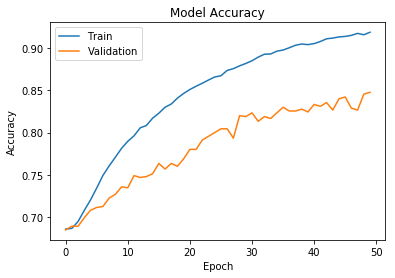

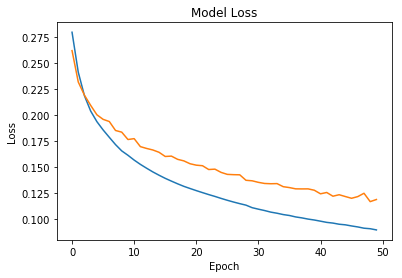

In [11]:
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("plots/subtask_b_second_gen_model_accuracy.png")
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig("plots/subtask_b_second_gen_model_loss.png")
plt.show()

In [14]:
from keras.models import load_model

malstm.save('model_24.01.h5')  # creates a HDF5 file 'my_model.h5'

# returns a compiled model
# identical to the previous one

In [23]:
import pickle

with open('history_model_24.01', 'wb') as outfile:
    pickle.dump(malstm_trained.history, outfile)



In [37]:
Y_test = test_df['relevance']
X_test['left'] = pad_sequences(X_test['left'], maxlen=max_seq_length)
X_test['right'] = pad_sequences(X_test['right'], maxlen=max_seq_length)

# # Make sure everything is ok
assert X_test['left'].shape == X_test['right'].shape
assert len(X_test['left']) == len(Y_test)


In [74]:
score_malstm = malstm.evaluate([X_test['left'], X_test['right']], Y_test, batch_size=32, verbose=1, sample_weight=None)

2395/2395 [==============================] - 6s 2ms/step


In [91]:
malstm.save("model_sobota")

In [15]:
Y_pred = malstm.predict([X_test['left'], X_test['right']])


ValueError: Error when checking : expected input_1 to have shape (None, 104) but got array with shape (2395, 1)

In [75]:
score_malstm

[0.10706617019308384, 0.87348643013729188]

In [87]:
Y_pred_mapped = list(map(give_class, Y_pred))

In [86]:
def give_class(x):
    return 1 if x>0.55 else 0
        

In [88]:
prediction_metric = metrics.precision_score(Y_test, Y_pred_mapped)
recall_metric = metrics.recall_score(Y_test, Y_pred_mapped)
roc_metric = metrics.roc_auc_score(Y_test, Y_pred_mapped)

f1_metric = metrics.f1_score(Y_test, Y_pred_mapped)

In [80]:
print(prediction_metric, recall_metric, roc_metric, f1_metric) # 0.5

0.860269360269 0.699042407661 0.824581299984 0.771320754717


In [85]:
print(prediction_metric, recall_metric, roc_metric, f1_metric) # 0.4

0.797619047619 0.824897400821 0.866475142718 0.811028917283


In [59]:
print(prediction_metric, recall_metric, roc_metric, f1_metric) # 0.3

0.634634634635 0.86730506156 0.823977050011 0.732947976879


In [89]:
print(prediction_metric, recall_metric, roc_metric, f1_metric) # 0.55

0.892929292929 0.604651162791 0.786400100626 0.721044045677


In [67]:
print(prediction_metric, recall_metric, roc_metric, f1_metric) # 0.6

0.952631578947 0.247606019152 0.621098682653 0.393051031488


In [13]:
malstm = load_model('model_24.01.h5')

In [7]:
X_test['right'], X_test['left'] test_df['relevance']

In [14]:
def display_metrics(Y, Y_pred):
    print(metrics.precision_score(Y, Y_pred),
          metrics.recall_score(Y, Y_pred),
          metrics.roc_auc_score(Y, Y_pred),
          metrics.f1_score(Y, Y_pred))
    
    

In [18]:
Y_pred = malstm.predict([X_test['left'], X_test['right']])

ValueError: Error when checking : expected input_1 to have shape (None, 104) but got array with shape (2395, 1)